In [1]:
%pylab inline
import numpy as np

import sys
sys.path.append('../core/')
from FFNN_generator import FFNN_Generator
from FFNN_net import pressure_encoder
from utils import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
dim = 16

data_path = '../../../Re_17500/'
dist_func = lambda d : (1-0.1)/(1+np.exp(((d-1)/0.1).clip(-np.inf, 35))) + 0.1
S = np.arange(50)*2
m_hist = 70
stride = 3
ind_min = 80

In [3]:
gen = FFNN_Generator(data_path, 
                     dist_func,
                     S=S, 
                     m_hist=m_hist, 
                     stride=stride, 
                     ind_min=ind_min)

model = pressure_encoder(restart_file = '../saved_models/FFNN_'+str(dim)+'.npy')

In [4]:
train_loss = model.train_loss
val_loss = model.val_loss

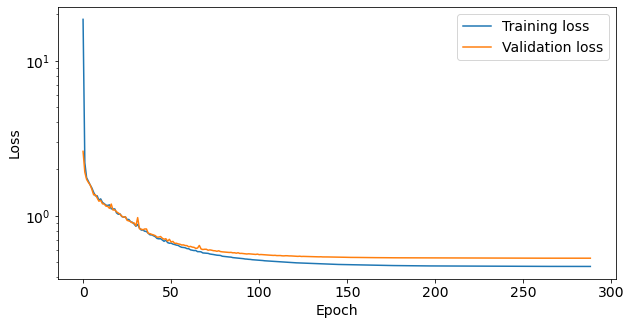

In [5]:
figure(figsize = (10,5))
label_fs = 14

semilogy(train_loss, label='Training loss')
semilogy(val_loss, label='Validation loss')

xlabel('Epoch', fontsize = label_fs)
ylabel('Loss', fontsize = label_fs)
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
legend(loc = 'upper right', fontsize = label_fs)

In [6]:
Xi = model.encode(gen.get_P_hist()).numpy()

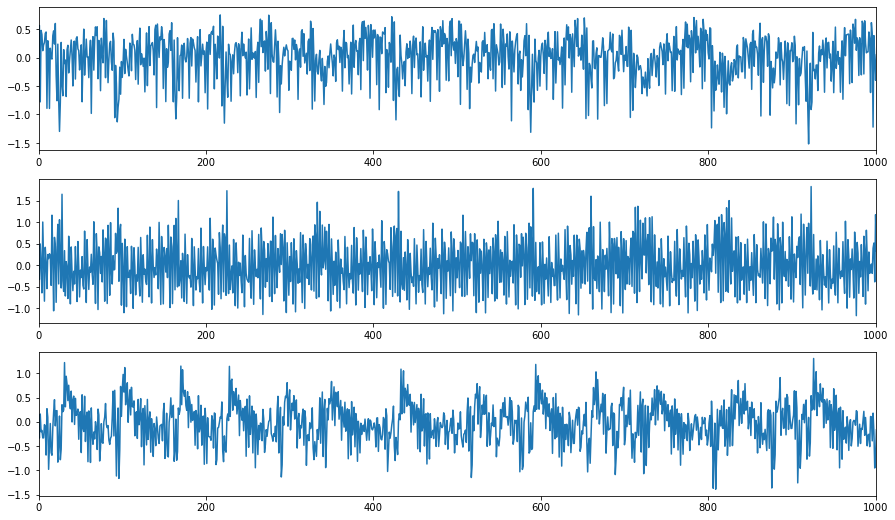

In [7]:
n_plot = 3

figure(figsize = (15,3*n_plot))

for j in range(n_plot):
    subplot(n_plot,1,j+1)
    plot((Xi - np.mean(Xi,axis=0))[:,j])
    xlim([0,1000])

In [8]:
snapshot_num = 3500
p_hist, X, U = gen.get_snapshot(snapshot_num)
xi = model.encode(p_hist).numpy()
U_hat = model.reconstruct(p_hist).numpy()[0,...]
wing_boundary_x, wing_boundary_y = get_wing_boundary()

3399 True
3599 False
3799 False
3999 False


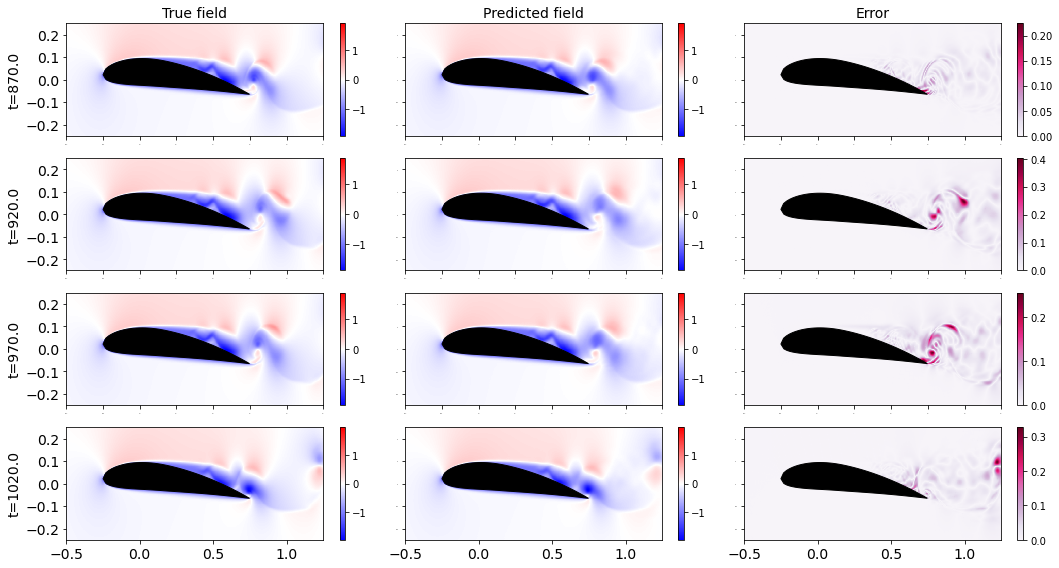

In [11]:
nx = 500
ny = 250

x = np.linspace(-0.5,1.25,nx)
y = np.linspace(-0.25,0.25,ny)
XX, YY = np.meshgrid(x, y)

snapshot_nums = [3399, 3599, 3799, 3999]
n_rows = len(snapshot_nums)
figure(figsize = (15,2*n_rows))

for j in range(n_rows):
    
    snapshot_num = snapshot_nums[j]
    print(snapshot_num, (snapshot_num in gen.train_inds))
    p_hist, X, U = gen.get_snapshot(snapshot_num)
    U_hat = model.reconstruct(p_hist).numpy()[0,...]
    
    u_grid = interp(U[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
    u_hat_grid = interp(U_hat[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
    
    max_abs = np.max(np.abs(np.stack([u_grid,u_hat_grid])))
    max_abs = np.max(np.abs(u_grid))
    
    subplot(n_rows,3,3*j+1)    
    pcolor(XX,YY,u_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
    fill(wing_boundary_x, wing_boundary_y, c='k')
    xlim([np.min(x),np.max(x)])
    ylim([np.min(y),np.max(y)])
    colorbar()
    
    yticks(fontsize = label_fs)
    ylabel('t='+str(20+(snapshot_nums[j]+1)*0.25), fontsize = label_fs)
    if j==0: title('True field', fontsize = label_fs)
    
    if j == n_rows-1:
        xticks([-0.5,0,0.5,1], fontsize = label_fs)
    else:
        xticks(fontsize = 0)
    
    subplot(n_rows,3,3*j+2)    
    pcolor(XX,YY,u_hat_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
    fill(wing_boundary_x, wing_boundary_y, c='k')
    xlim([np.min(x),np.max(x)])
    ylim([np.min(y),np.max(y)])
    colorbar()
    
    yticks(fontsize = 0)
    if j==0: title('Predicted field', fontsize = label_fs)
    
    if j == n_rows-1:
        xticks([-0.5,0,0.5,1], fontsize = label_fs)
    else:
        xticks(fontsize = 0)
    
    subplot(n_rows,3,3*j+3) 
    max_err = np.max(np.abs(u_grid-u_hat_grid))
    pcolor(XX,YY,np.abs(u_grid-u_hat_grid), cmap='PuRd', vmin=0, vmax=max_err, shading='auto')
    fill(wing_boundary_x, wing_boundary_y, c='k')
    xlim([np.min(x),np.max(x)])
    ylim([np.min(y),np.max(y)])
    colorbar()
    
    yticks(fontsize = 0)
    if j==0: title('Error', fontsize = label_fs)
    
    if j == n_rows-1:
        xticks([-0.5,0,0.5,1], fontsize = label_fs)
    else:
        xticks(fontsize = 0)
        
tight_layout()